# Википедия Сюжеты фильмов EDA

В этом ноутбуке мы выполняем исследовательский анализ данных, основанный на [набора данных Wikipedia Movie Plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots).

Первым шагом является импорт всех необходимых библиотек. Сначала мы импортируем основные библиотеки. В дальнейшем будем хранить все импорты в одном месте. Затем мы предоставим путь к файлу и прочитаем данные.

In [ ]:
!pip wordcloud

ERROR: unknown command "wordcloud"


In [ ]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
print("Setup Complete")

Setup Complete


In [6]:

from google.colab import files
uploaded = files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
my_data = pd.read_csv('wiki_movie_plots_deduped.csv')
my_data.head()

## Контекст
Краткое описание набора данных из Wikipedia.

## Содержание
Набор данных содержит описания 34 886 фильмов со всего мира. Ниже перечислены описания столбцов:

* Release Year - Год, в котором был выпущен фильм
* Title - Название фильма
* Происхождение/Этническая принадлежность - Происхождение фильма (т.е. американский, болливудский, тамильский и т.д.)
* Директор - Директор(ы)
* Сюжет - Главные актеры и актрисы
* Жанр - Жанр(ы) фильма
* Wiki Page — URL-адрес страницы Википедии, с которой было скопировано описание сюжета
* Сюжет - Подробное описание сюжета фильма (ВНИМАНИЕ: может содержать спойлеры!!)

Давайте взглянем на первые несколько строк набора данных.

In [ ]:
my_data.head()

Как мы видим, большая часть данных категориальны, поэтому нам нужно будет принять это во внимание при принятии решения о том, какие столбцы выбрать для этого датсета.

Теперь давайте получим основную информацию об этом наборе данных.

In [ ]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
Release Year        34886 non-null int64
Title               34886 non-null object
Origin/Ethnicity    34886 non-null object
Director            34886 non-null object
Cast                33464 non-null object
Genre               34886 non-null object
Wiki Page           34886 non-null object
Plot                34886 non-null object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


Данные довольно массивные, содержащие около 35 тыс. наблюдений. Это целесообразно при рассмотрении вопроса о создании модели машинного обучения на основе этих данных. Существует 8 столбцов/переменных, описывающих данные. Только столбец "Releae Year" является числовым, остальные - категориальные.

# Визуализация данных
### Тренд киноиндустрии

Во-первых, давайте посмотрим на общую тенденцию в индустрии кинопроизводства за столетие.

Text(0.5, 1.0, 'Number of movies realsed around the world \n over the years')

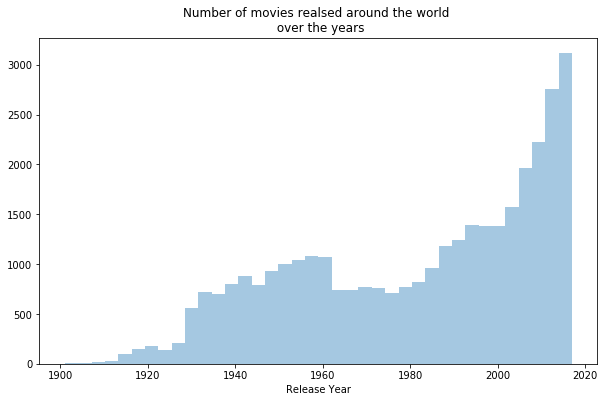

In [ ]:
# Check out the overall trend in movie releases over the years around the world
plt.figure(figsize=(10,6))
sns.distplot(a=my_data["Release Year"], kde=False)
plt.title("Number of movies realsed around the world \n over the years", loc="center")

Похоже, он растет почти в геометрической прогрессии! Давайте разберемся, кто является драйвером этого роста.

# Мировые лидеры

In [ ]:
my_data.rename(columns={"Origin/Ethnicity":"Origin"}, inplace=True)

# How many Origins are there in the dataset?
len(my_data["Origin"].unique())

24

Text(-8.950000000000003, 0.5, '')

<Figure size 720x360 with 0 Axes>

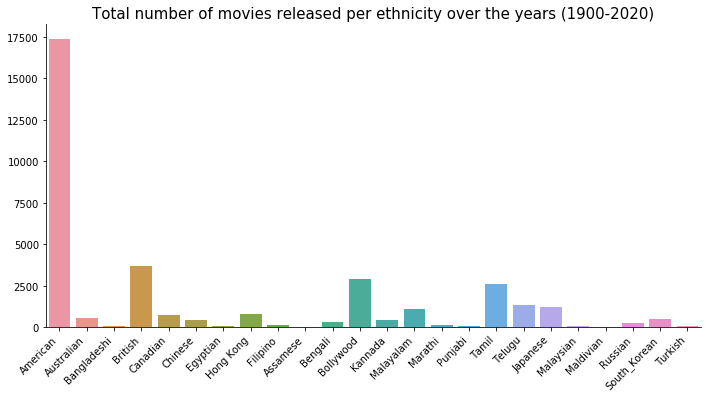

In [ ]:
plt.figure(figsize=(10,5))
sns.catplot(x="Origin", kind="count", data=my_data, height=5, aspect=2)
plt.xticks(rotation=45,
    horizontalalignment='right')
plt.title("Total number of movies released per ethnicity over the years (1900-2020)", fontsize=15)
plt.xlabel("")
plt.ylabel("")

Из 24 источников, представленных в датафрейме, США являются безусловным лидером.

Интересно отметить, что существует довольно много этнических групп, принадлежащих к Индии. Чтобы упростить дальнейший анализ, давайте добавим новый столбец в этот фрейм данных, содержащий страны, к которым относятся эти этнические группы.

In [ ]:
equiv_dict = {"American":"The US", "Australian":"Australia", "Bangladeshi":"Bangladesh",
              "British":"The Great Britain", "Canadian":"Canada", "Chinese":"China",
              "Egyptian":"Egypt", "Hong Kong":"Hong Kong", "Fillipino":"The Phillipins",
              "Assamese":"India", "Bengali":"India", "Bollywood":"India", "Kannada":"India",
              "Malayalam":"India", "Marathi":"India", "Punjabi":"India", "Tamil":"India",
              "Telugu":"India", "Japanese":"Japan", "Malaysian":"Malaysia", "Maldivian":"Maldives",
              "Russian":"Russia", "South_Korean":"South_Korea","Turkish":"Turkey"}
my_data["Country"] = my_data["Origin"].map(equiv_dict)

Text(-8.950000000000003, 0.5, '')

<Figure size 720x360 with 0 Axes>

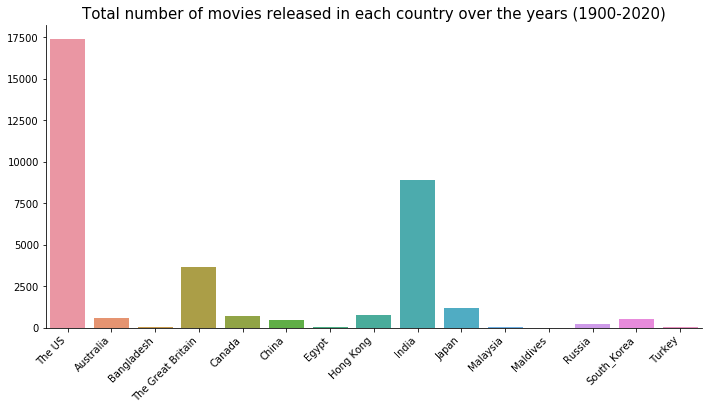

In [ ]:
plt.figure(figsize=(10,5))
sns.catplot(x="Country", kind="count", data=my_data, height=5, aspect=2)
plt.xticks(rotation=45,
    horizontalalignment='right')
plt.title("Total number of movies released in each country over the years (1900-2020)", fontsize=15)
plt.xlabel("")
plt.ylabel("")

Таким образом, анализировать данные намного проще, так как категорий меньше.

Сейчас мы видим, что второе место принадлежит Индии, которая за столетие произвела в два раза меньше фильмов, чем США. За ней следуют Великобритания и Япония, у которых кинопроизводство значительно ниже, чем у 2 лидеров.

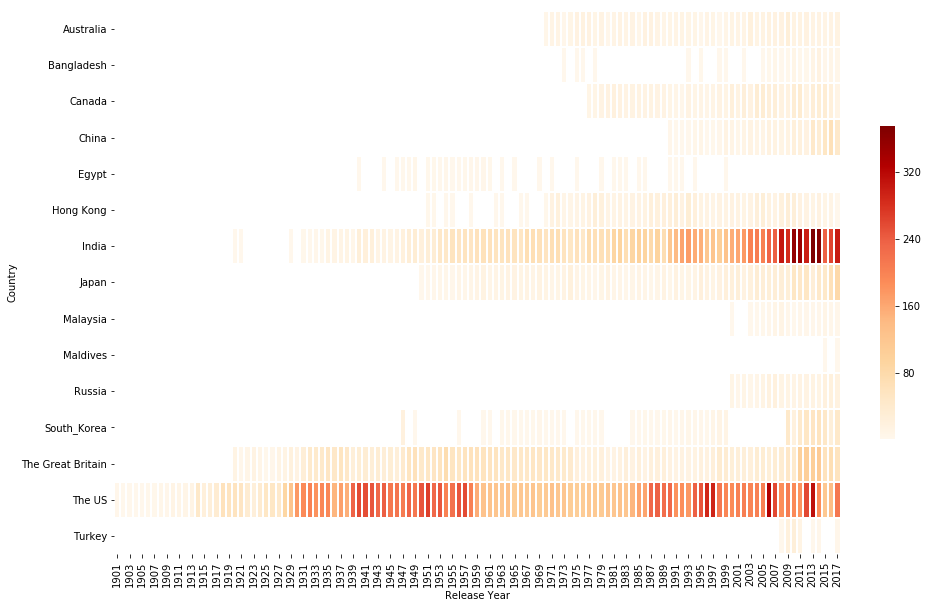

In [ ]:
# Group the data by the "Country" and "Release Year" columns
# to make visual the periods when the movie production was the most intensive for different countries.
by_country_by_year = my_data.groupby(["Country","Release Year"]).size().unstack()

plt.figure(figsize=(14,10))
g = sns.heatmap(
    by_country_by_year,
    #square=True, # make cells square
    cbar_kws={'fraction' : 0.02}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

Мы видим, что все 4 лидера начали предпринимать шаги гораздо раньше, чем большинство других стран. Это отчасти объясняет такую большую разницу в цифрах.

# США

Если мы посмотрим **на цифры по США**, то увидим, что киноиндустрия развивалась поступательно до 1960-х годов. В течение следующих 20 лет наблюдался спад, а затем снова начал расти. Это снижение объясняется в этой статье:: https://en.wikipedia.org/wiki/New_Hollywood

Короче говоря, появление телевидения и сильно изменившаяся демографическая аудитория (молодое поколение) положили конец «Старому Голливуду», а «Новый Голливуд» только начинал развиваться.

Еще одной причиной гораздо более быстрого роста американской киноиндустрии за последние 20 лет может быть начало цифровой эпохи, которая сделала производство фильмов дешевле и намного быстрее.

Теперь давайте поближе познакомимся с индийской киноиндустрией.

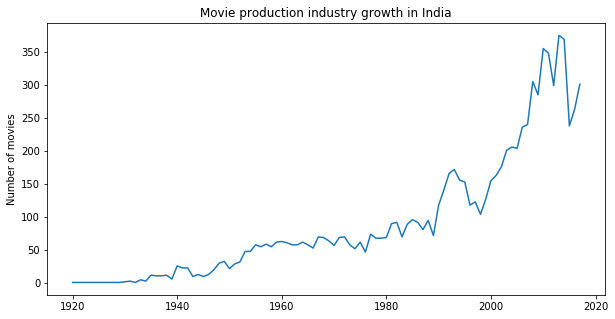

In [ ]:
india = my_data[["Country", "Release Year"]].query('Country == "India" ').groupby("Release Year").size()

plt.figure(figsize=(10,5))
plt.title("Movie production industry growth in India")
plt.ylabel("Number of movies")
sns.lineplot(data=india)

# Индия

Мы ясно видим, что индийская киноиндустрия неуклонно росла до 1980-х годов. В конце 1980-х годов кино на хинди пережило период застоя из-за роста насилия, снижения музыкального мелодичного качества и роста видеопиратства, что привело к тому, что семейная аудитория среднего класса покинула кинотеатры.

Поворотным моментом стал музыкальный романс «Чандни» (1989). Он сыграл важную роль в завершении эпохи жестоких боевиков в индийском кино и возрождении романтического музыкального жанра. Он также установил новый шаблон для болливудских музыкальных романтических фильмов, которые определили кино на хинди в последующие годы.

Ссылка: https://en.wikipedia.org/wiki/Cinema_of_India#New_Bollywood_(1990s%E2%80%93present)

Начиная с 2000 года, он растет гораздо более высокими темпами. Отчасти это может быть связано с растущим населением Индии.

http://statisticstimes.com/demographics/population-of-india.php

Цифровая эпоха, вероятно, также повлияла на скорость производства фильмов.

# Жанры кино

Было бы интересно сравнить, какие жанры наиболее популярны в разных странах.

Для начала визуализируем данные столбца «График» с помощью облаков слов для 2-х лидеров – США и Индии.


### США

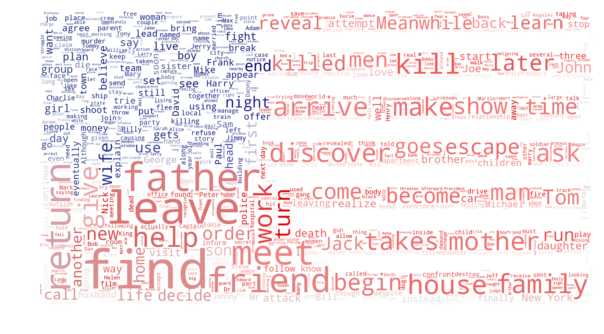

In [ ]:
# American word cloud

# Generate a word cloud image
usa = " ".join(plot for plot in my_data[my_data["Country"]=="The US"].Plot)
d = '../input/flags-pics2/'
usa_mask = np.array(Image.open(d + 'american-flag-1399556531Ci4.jpg'))
stopwords=set(STOPWORDS)
stopwords.update(["tell",'tells',"take","one","two","see","will","now"])
wordcloud_usa = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=1000, mask=usa_mask).generate(usa)

# create coloring from image
image_colors = ImageColorGenerator(usa_mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

Наиболее распространенными словами, используемыми в колонке сюжета для американских фильмов, являются:

* находить
* покидать
* возвращать
* отец
* друг
* Дом
* убивать
* встречать
* Справка

Это указывает на такие жанры, как «мистика», «драма», «триллер», возможно, некоторые «романтика» и «мелодрама», как правило, являются наиболее частыми.

### Индия

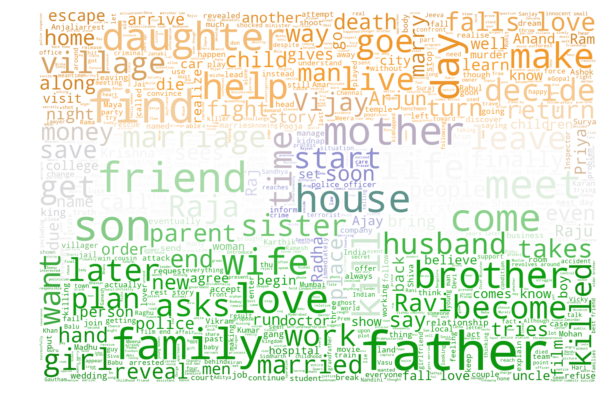

In [ ]:
# Indian word cloud

# Generate a word cloud image
india = " ".join(plot for plot in my_data[my_data["Country"]=="India"].Plot)
d = '../input/flags-pics2/'
india_mask = np.array(Image.open(d + 'india-flag.jpg'))
stopwords=set(STOPWORDS)
stopwords.update(["tell",'tells',"take","one","two","see","will","now","meanwhile","give","ask"])
wordcloud_india = WordCloud(stopwords=stopwords, background_color="white", mode="RGBA", max_words=1000, mask=india_mask).generate(india)

# create coloring from image
image_colors = ImageColorGenerator(india_mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_india.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.show()

TНаиболее распространенными словами, используемыми в колонке сюжета для индийских фильмов, являются:

* отец
* мать
* друг
* сын
* семья
* Дом
* любовь
* убивать
* Жизнь
* находить

Из этого беглого анализа следует, что семья является важной ценностью в Индии (что является общеизвестным в индийской культуре). Так что логично, что фильмы снимаются на эту тему. Важными словами являются также «убить», «жизнь» и «найти». Из этого можно сделать вывод, что наибольшей популярностью среди индийской аудитории будут пользоваться такие жанры, как «детектив», «триллер», «криминал», «драма».

Теперь давайте посмотрим в реальности, какие жанры наиболее популярны в этом датасете. Мы проведем этот анализ для двух лидеров - США и Индии - чтобы иметь возможность сравнить результаты с нашими прогнозами, сделанными из облаков слов. Поскольку в датасете 2265 жанров, сначала мы выделим 20 наиболее распространенных из них.

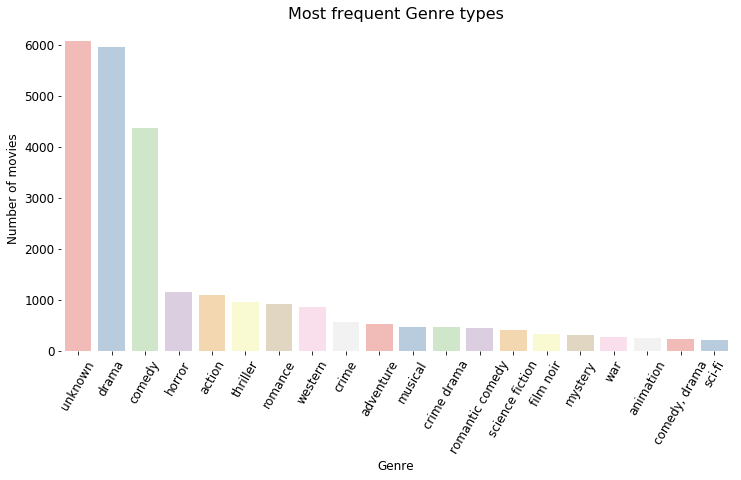

In [ ]:
pop_genres = list(my_data.Genre.unique())[:20]

plt.figure(figsize=(12,6))

sns.countplot(my_data.Genre,order=pd.value_counts(my_data.Genre).iloc[:20].index,palette=sns.color_palette("Pastel1", 20))
plt.title('Most frequent Genre types',fontsize=16)
plt.ylabel('Number of movies', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.xticks(size=12,rotation=60)
plt.yticks(size=12)
sns.despine(bottom=True, left=True)
plt.show()


Наиболее частым жанром является «неизвестный», вероятно, из-за некоторых проблем со сбором данных. К сожалению, это подмножество фрейма данных не очень полезно для нашей цели, поэтому мы можем пока не обращать на него внимания. Однако в случае создания алгоритма машинного обучения, предсказывающего жанр фильма, эти данные могут быть использованы для тестирования конечной рабочей модели на каких-то реальных данных.

Теперь давайте составим тепловую карту, которая покажет, какой жанр кино из топ-20 жанров наиболее популярен в разных странах.

p.s. Поскольку данные о жанрах довольно беспорядочны, перед созданием модели машинного обучения их следует очистить/предварительно обработать таким образом, чтобы мы определили все существующие жанровые категории и пометили этими категориями каждую строку набора данных.

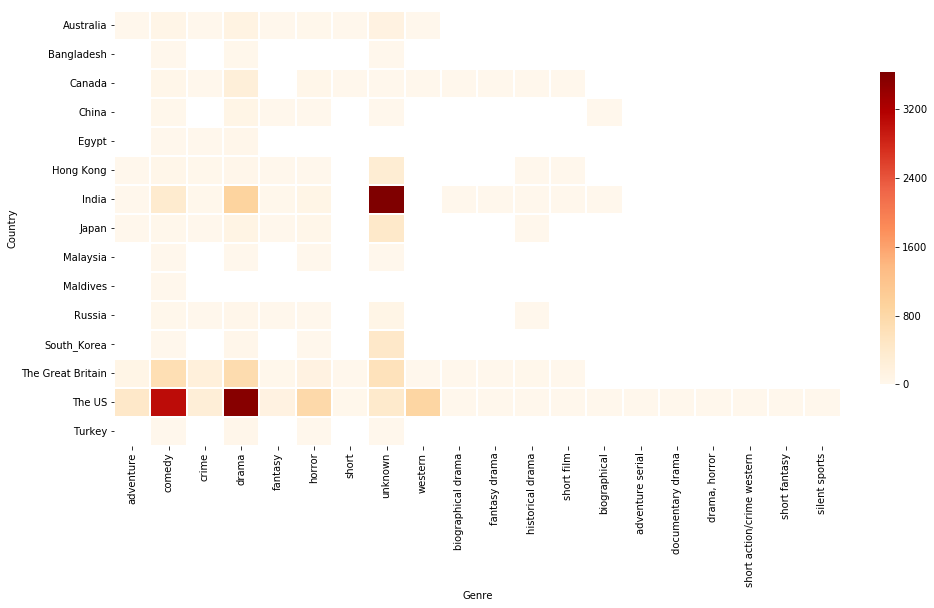

In [ ]:
by_country_by_genre = my_data.groupby(["Country","Genre"]).size().unstack()
by_genre_top20 = by_country_by_genre.loc[:, by_country_by_genre.columns.isin(pop_genres)]

plt.figure(figsize=(14,8))
sns.heatmap(
    by_genre_top20,
    #square=True, # make cells square
    cbar_kws={'fraction' : 0.02}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

Как мы видим, в США самыми популярными жанрами являются «драма», «комедия», «ужасы», «вестерн» и «приключения». За исключением жанра «комедия» (который, как мне кажется, трудно предсказать по простому облаку слов), наш прогноз соответствует действительности.

Что касается индийских данных, то большая часть информации о жанрах отсутствует, поэтому увидеть реальную картину гораздо сложнее, но мы видим, что «драма» и «комедия» также преобладают. Такую же ситуацию мы можем наблюдать и в данных британского кино.

## Лучшие режиссеры и актерский состав
В конце концов, давайте посмотрим, кто является самым эффективным режиссером, который снял большинство фильмов, и самым популярным выбором актеров.

Мы удалим значения "Unknown" director и null cast, чтобы сделать анализ более понятным. Кроме того, при анализе данных Cast мы заметили несколько небольших проблем. Во-первых, один и тот же персонаж был назван 2 разными способами: «Три балбеса» и «Три балбеса». Это повлияло на отражение данных, поэтому мы исправили это, объединив их. Во-вторых, при удалении нулевых значений мы заметили, что в некоторых строках данных есть не только нулевые значения, но и неразрывные пробелы, поэтому мы удалили и их.

### В главных ролях

In [ ]:
# Getting rid of null values and invisible characters (non-breaking spaces)
top_cast = my_data[(my_data.Cast.notnull()) & (my_data.Cast != " ")]
top_cast.set_index("Cast",inplace=True)
top_cast.rename(index={'Three Stooges':'The Three Stooges'},inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


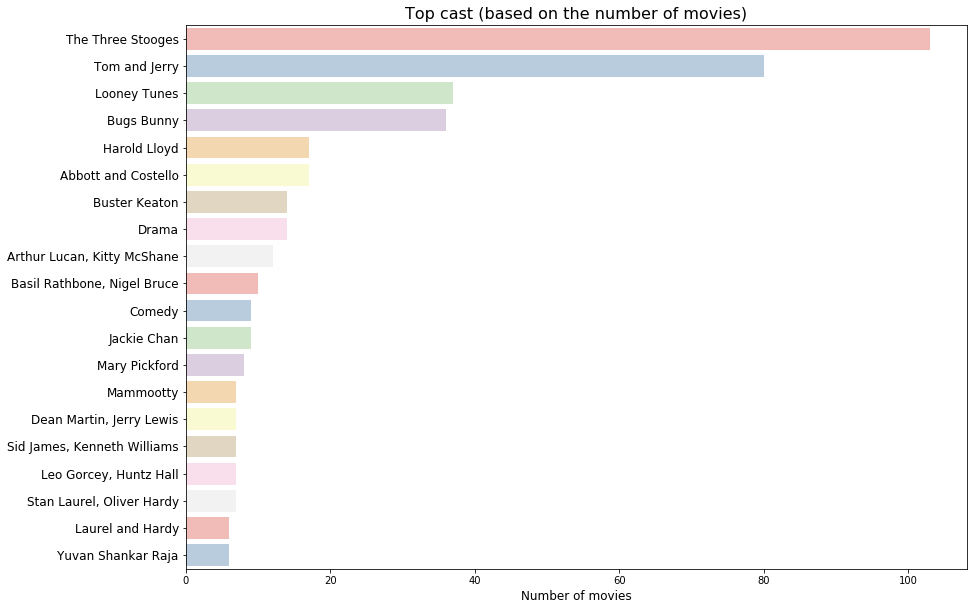

In [ ]:
plt.figure(figsize=(14,10))
plt.title('Top cast (based on the number of movies)',fontsize=16)

sns.countplot(y=top_cast.index,order=pd.value_counts(top_cast.index)[:20].index,palette=sns.color_palette("Pastel1", 20))

plt.xlabel('Number of movies',fontsize=12)
plt.ylabel('',fontsize=12)
plt.yticks(size=12)
plt.show()

Безусловно, наиболее частым приведением этого фрейма данных является ... The Three Stooges, американская водевильная и комедийная команда, действовавшая с 1922 по 1970 год, наиболее известная своими 190 короткометражными фильмами Columbia Pictures, которые регулярно транслировались по телевидению с 1958 года.

https://en.wikipedia.org/wiki/The_Three_Stooges

Второе место принадлежит Тому и Джерри :) Это американский мультсериал комедийных короткометражных фильмов, созданный в 1940 году Уильямом Ханной и Джозефом Барберой. Наиболее известный своими 161 короткометражными фильмами от Metro-Goldwyn-Mayer, сериал сосредоточен на соперничестве между главными героями, котом Томом, и мышонком Джерри. Они выиграли семь премий «Оскар» в номинации «Анимационный короткометражный фильм».

https://en.wikipedia.org/wiki/Tom_and_Jerry

### Top directors

In [ ]:
top_director = my_data[my_data.Director != "Unknown"]

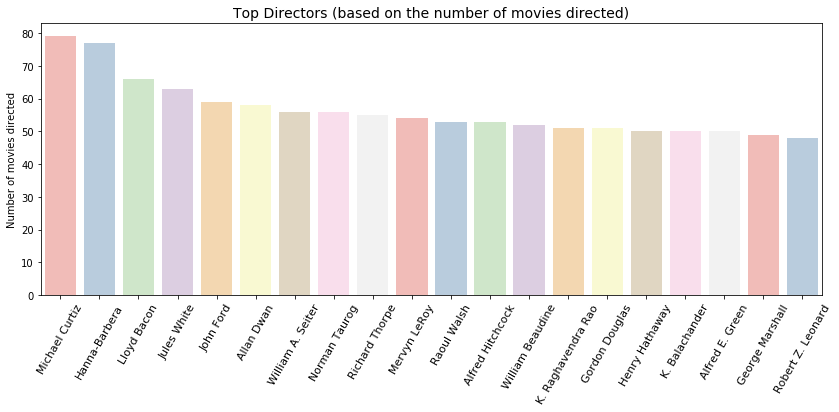

In [ ]:
plt.figure(figsize=(14,5))
plt.title('Top Directors (based on the number of movies directed)',fontsize=14)

sns.countplot(top_director.Director,order=pd.value_counts(top_director.Director)[:20].index,palette=sns.color_palette("Pastel1", 20))

plt.xlabel('',fontsize=10)
plt.ylabel('Number of movies directed',fontsize=10)
plt.xticks(size=11,rotation=60)
plt.show()

Разница между режиссерами в данном случае кажется менее заметной, но если учесть, что съемки даже 1 фильма могут потребовать многих лет работы, то это меняет восприятие данных.

Лучшим режиссером по количеству снятых фильмов является Майкл Кертис, американский кинорежиссер венгерского происхождения. Статья в Википедии о Майкле Кёртисе подтверждает, что он признан одним из самых плодовитых режиссеров в истории. Он был пять раз номинирован на «Оскар» и выиграл дважды, один раз за лучший короткометражный фильм за «Сынов свободы» и один раз за лучшую режиссуру за «Касабланку».

https://en.wikipedia.org/wiki/Michael_Curtiz

Ханна-Барбера занимает второе место, и это не удивительно, поскольку эти 2 режиссера (Уильям Ханна и Джозеф Барбера) спродюсировали мультфильм «Том и Джерри», который занимает второе место в самом частом актерском составе этого датафрейма!

# Заключение
* В этом анализе мы обнаружили, что набор данных Wikipedia Movie Plots содержит огромные данные (~35 тыс. фильмов). Это может быть преимуществом при рассмотрении вопроса о создании модели прогнозирования жанра или системы рекомендаций.
* Общая тенденция мировой киноиндустрии близка к экспоненциальному росту, который возглавляют США и Индия, за ними следуют Великобритания и Япония.
* Мы более подробно рассмотрели причины такого роста в США и Индии.
* Мы изучили самые популярные жанры фильмов из этого набора данных и попытались предсказать наиболее часто встречающиеся жанры для США и Индии на основе облаков слов.
*Наконец, мы определили лучших режиссеров и актеров этого датафрейма, оба американцы. «Три балбеса» — самый популярный актерский состав, а Майкл Кертис — лучший режиссер по количеству снятых фильмов.

Дальнейшая работа над этим набором данных будет включать в себя разработку алгоритма прогнозирования жанра и/или системы рекомендаций.